In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [2]:
def get_significant(file_path):
    significants = []
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas[1:]:
            data = data.split()
            x, y = int(int(data[1])/1000), int(int(data[3])/1000)
            p_value, q_value = float(data[5]), float(data[6])
            concat = int(data[4])
            significants.append((x, y, p_value, q_value, concat))
    return significants

def cal_significant(significants, proportion):
    test = np.array(significants)
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _p_values = test[:, 2]
    _test = _filter(_p_values, int(_p_values.shape[0]*proportion), test)
    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

def show_venn(enhanced_sig_set, hr_sig_set):
    venn2(subsets = [hr_sig_set, enhanced_sig_set], set_labels = ('1kb', 'enhanced'), set_colors=((247/255, 129/255, 191/255), (51/255, 160/255, 44/255)))
    plt.show()

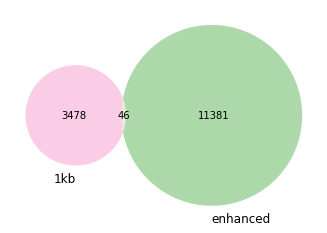

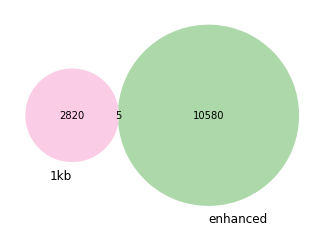

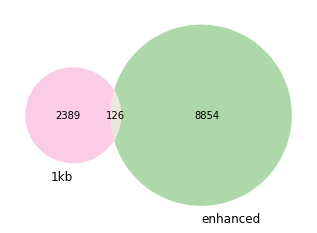

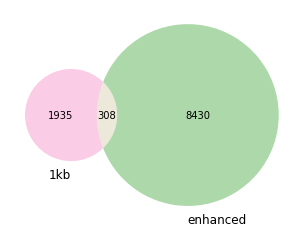

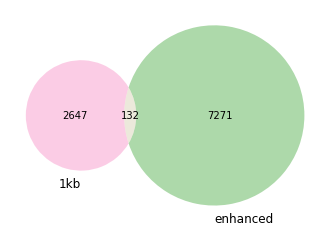

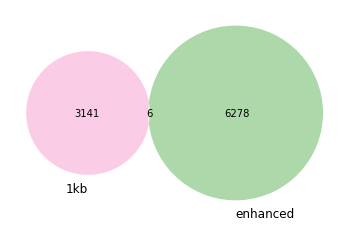

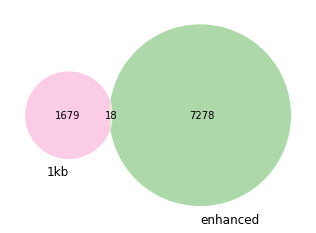

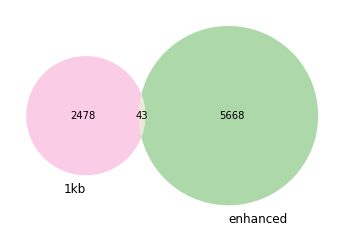

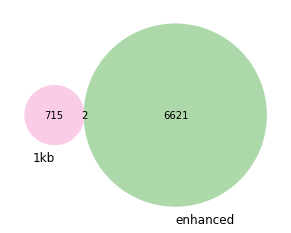

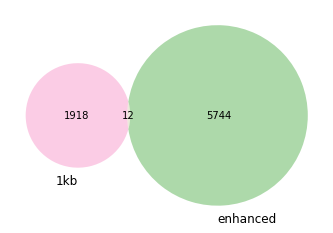

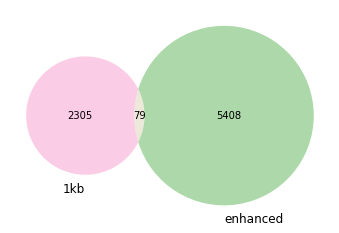

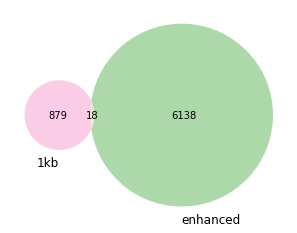

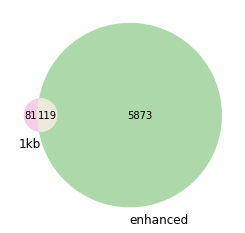

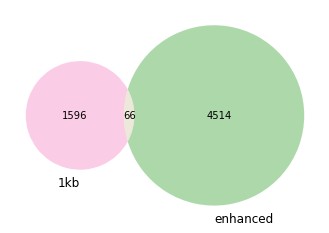

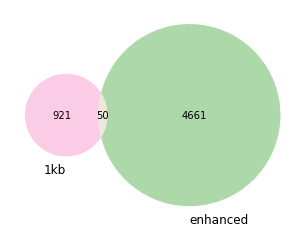

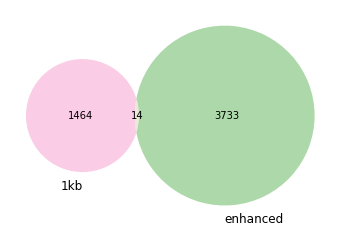

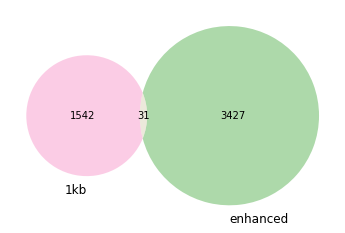

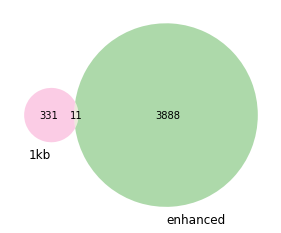

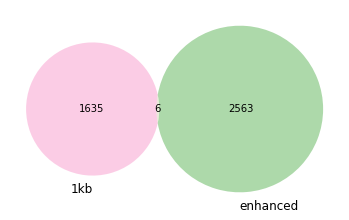

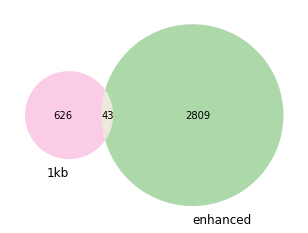

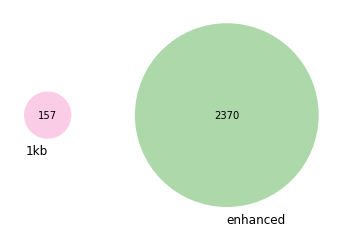

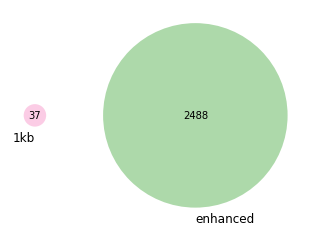

In [3]:
analyse_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac/analyse/GM12878_ATAC_H3K27ac'
enhanced_path = os.path.join(analyse_path, 'experiment', 'loop', 'enhanced')
hr_path = os.path.join('/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/GM12878_ATAC_H3K27ac_H3K4me3', 'experiment', 'loop', 'hr')
auxiliary_files_path = os.path.join('/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/GM12878_ATAC_H3K27ac_H3K4me3', 'experiment', 'auxiliary_files')
proportion = 0.015

# 未去交集的全部sig
enhanced_sigs = set()
hr_sigs = set()
# 去交集的全部sig
all_enhanced_sig = dict()
all_hr_sig = dict()
for chr in range(1, 23):
    enhanced_file_path = os.path.join(enhanced_path, 'chr{}_1000b'.format(chr), 'outputs_2_300', 'FitHiC.spline_pass1.res1000.significances.txt')
    hr_file_path = os.path.join(hr_path, 'chr{}_1000b'.format(chr), 'outputs_2_300', 'FitHiC.spline_pass1.res1000.significances.txt')
    enhanced_sig = cal_significant(get_significant(enhanced_file_path), proportion)
    hr_sig = cal_significant(get_significant(hr_file_path), proportion)
    
    _enhanced_sig = set(list(map(tuple, np.array(enhanced_sig)[:, :2])))
    _hr_sig = set(list(map(tuple, np.array(hr_sig)[:, :2])))
    show_venn(_enhanced_sig, _hr_sig)
    # 去交集
    new_enhanced_sig = _enhanced_sig - _hr_sig
    new_hr_sig = _hr_sig - _enhanced_sig
    
    all_enhanced_sig[chr] = new_enhanced_sig
    all_hr_sig[chr] = new_hr_sig
    
    for sig in _enhanced_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        enhanced_sigs.add(tuple(_sig))
    for sig in _hr_sig:
        _sig = list(sig)
        _sig.append('chr{}'.format(chr))
        hr_sigs.add(tuple(_sig))

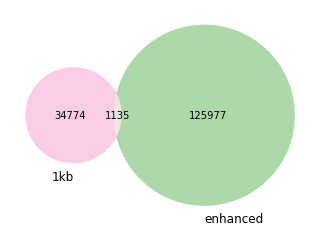

KeyboardInterrupt: 

In [4]:
show_venn(enhanced_sigs, hr_sigs)

_enhanced_sigs = enhanced_sigs.copy()
_hr_sigs = set()
for _hr_sig in hr_sigs:
    flag = False
    for _enhanced_sig in _enhanced_sigs:
        if abs(_hr_sig[0]-_enhanced_sig[0])<3 and abs(_hr_sig[1]-_enhanced_sig[1])<3:
            _hr_sigs.add(_enhanced_sig)
            flag = True
    _hr_sigs.add(_hr_sig)
    if flag:
        _enhanced_sigs.add(_hr_sig)

show_venn(_enhanced_sigs, _hr_sigs)

In [5]:
attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, mine_result, hr_result):
    sns.set_style("whitegrid") 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axes.grid(False)
    axes.plot(x, mine_result, color=(51/255, 160/255, 44/255), label='mine')
    axes.plot(x, hr_result, color=(177/255, 89/255, 40/255), label='hr')

    plt.xlabel('distance')
    plt.ylabel('nums')
    plt.legend()
    plt.show()

def figure(chip_seq_path):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        _peaks = read_chiqseq_file(chip_seq_path)
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], _peaks['chr{}'.format(chr)])
        hr_result = get_hit_indicators(all_hr_sig[chr], _peaks['chr{}'.format(chr)])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

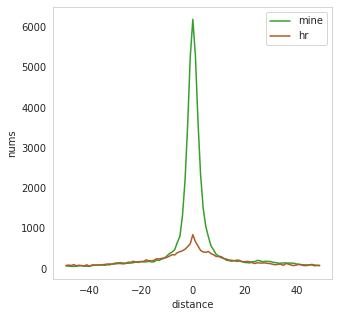

In [6]:
chip_seq_path = os.path.join(auxiliary_files_path, 'CTCF_peaks.bed')
figure(chip_seq_path)

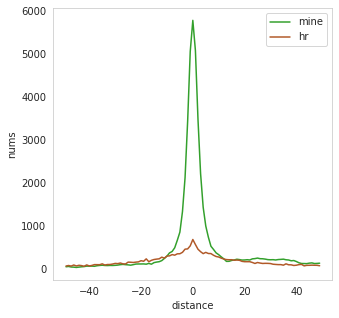

In [7]:
chip_seq_path = os.path.join(auxiliary_files_path, 'RAD21_peaks.bed')
figure(chip_seq_path)

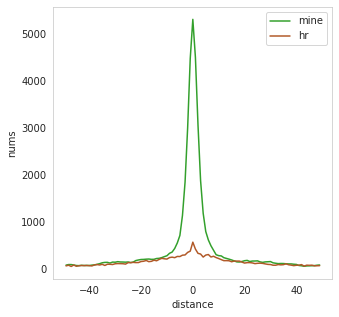

In [8]:
chip_seq_path = os.path.join(auxiliary_files_path, 'SMC3_peaks.bed')
figure(chip_seq_path)

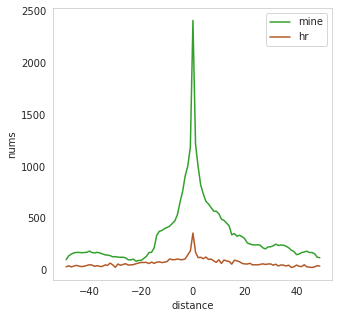

In [9]:
chip_seq_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
figure(chip_seq_path)

In [10]:
np.save('temp/GM12878_ATAC_H3K27ac_2_300_all_enhanced_sig.npy', all_enhanced_sig)
np.save('temp/GM12878_ATAC_H3K27ac_2_300_all_hr_sig.npy', all_hr_sig)